# <span style="color:red"> Looking at pairs of features, Part 1 </span>

In [8]:
# !pip install datascience   # You need to un-comment this line when you
                             # run the notebook on Azure

In [9]:
# Import code libraries or "modules" in Python lingo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import sys
from datascience import *
sns.set_style("whitegrid")
%matplotlib inline

**Note**

If you want to run this notebook on Azure, its easiest to upload the notebook, the file "datascience_extensions.py" (on Canvas) and the file "titanic3-table.csv" (on Canvas) and then replace the next two cells (below) by a single code cell
with the following two lines:

from datascience_extensions import * <br>
titanic = Table.read_table("titanic3-table.csv")

A summary of the methods to Table is [here](http://data8.org/datascience/tables.html) <br>
A tutorial for the datascience module is [here](http://data8.org/datascience/tutorial.html) <br>
A cheatsheet for the datascience module is [here](https://github.com/wstuetzle/STAT180/blob/master/Computing/data8_sp17_midterm_ref_sheet.pdf)

In [10]:
# Import some new methods for class Table
# Add IDS directory to search path

course_dir = "/Users/wxs/Dropbox/IDS/Git-reps/STAT180/"
computing_dir = course_dir + "Computing"

if computing_dir not in sys.path:
    sys.path.append(computing_dir)

from datascience_extensions import *

# Reload the extensions after we make a change
# Importing it again does not work - a module is imported only once
module_name = "datascience_extensions"
importlib.reload(sys.modules[module_name])

<module 'datascience_extensions' from '/Users/wxs/Dropbox/IDS/Git-reps/STAT180/Lectures/datascience_extensions.py'>

A summary of the methods for Table is [here](http://data8.org/datascience/tables.html) <br>
A tutorial for the datascience module is [here](http://data8.org/datascience/tutorial.html) <br>
A cheatsheet for the datascience module is [here](https://github.com/wstuetzle/STAT180/blob/master/Computing/data8_sp17_midterm_ref_sheet.pdf)

In [11]:
# Load the titanic table
data_dir = course_dir + "Data/"
titanic_filename = "titanic3-table.csv"
titanic_pathname = data_dir + titanic_filename
titanic = Table.read_table(titanic_pathname)

In [12]:
titanic.show(3)

pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON"
1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,nan,nan,"Montreal, PQ / Chesterville, ON"


In [13]:
titanic.shape()

[1309, 14]

In [14]:
# Let's make a subset of the Titanic data that has only the variables
# of interest to us, and only complete rows

titanic_sub = titanic.drop("name", "sibsp", "parch", "ticket", "fare", "cabin", "boat", 
                           "body", "home.dest").take_complete_rows()
titanic_sub.show(3)
titanic_sub.shape()

pclass,survived,sex,age,embarked
1,1,female,29,S
1,1,male,0.9167,S
1,0,female,2,S


[1044, 5]

### <span style="color:blue"> Feature types </span>

We distinguish between

* unordered categorical features ("sex", "embarked")
* ordered categorical features ("pclass")
* numerical features ("age")

For unordered categorical features, values can be either the same or different.
There are no notions of order or distance.

For ordered categorical features, category c1 can be larger, the same, or smaller than category c2.

For numerical features there are notions of order and distance - it makes sense to compute and compare differences between values.

### <span style="color:blue"> Types of pairs </span>

There are three possible types of pairs:

* Both features categorical
* One feature categorical, one feature numerical
* Both features numerical

### <span style="color:blue"> Looking at a pair of categorical features </span>

In [15]:
# Consider the features "pclass" and "survived"
# The "pivot" method finds the counts for the 6 combinations of categories

pivot_table = titanic_sub.pivot("survived", "pclass")
pivot_table

# There are 179 first class passengers who survived and 103 who did not, etc
#
# Note: The 1st argument specifies the columns, the 2nd specifies the rows
#       unfortunate!

pclass,0.0,1.0
1,103,179
2,146,115
3,370,131


In [16]:
type(pivot_table)

datascience.tables.Table

In [17]:
pivot_table.labels

('pclass', '0.0', '1.0')

In [18]:
pivot_table.column("1.0")

array([179, 115, 131])

**Conditional distributions**

When looking at the two features "pclass" and "survived", the question of interest is whether the fraction of survivors is different for different cabin classes.

If the fraction is different we say

* "There is an association between the features 'pclass' and 'survived',  or more informally
* "survival depends on cabin class".

To answer this questions, the table "pclass_survived" which has counts is not the most convenient. It would be more convenient to have the relative frequencies of survivors and casualties in each row. Let's compute that.

In [19]:
# First define some new variables to make the code easier to read

cond_dist = titanic_sub.pivot("survived", "pclass")

num_columns = cond_dist.num_columns
num_rows = cond_dist.num_rows
column_labels = cond_dist.labels

print("number of rows = " + str(num_rows))
print("number of columns  = " + str(num_columns))
print(column_labels)


number of rows = 3
number of columns  = 3
('pclass', '0.0', '1.0')


In [20]:
cond_dist

pclass,0.0,1.0
1,103,179
2,146,115
3,370,131


In [21]:
# Now let's replace the counts in each row by relative frequencies
# First form an array containing the row sums

# Google "numpy fill array"
#
row_sum = np.full(num_rows, 0)  # Makes an array with num_rows element, 
                                # all equal to 0

for i in np.arange(1, num_columns):
    row_sum = row_sum + cond_dist.column(i)

row_sum

array([282, 261, 501])

In [22]:
# Now divide each column by the row sums

for column_index in np.arange(1, num_columns):
    the_column = cond_dist.column(column_index)
    rel_freq = the_column / row_sum
    cond_dist = cond_dist.with_column(column_labels[column_index], rel_freq)
    
conditional_given_pclass = cond_dist
    
conditional_given_pclass

pclass,0.0,1.0
1,0.365248,0.634752
2,0.559387,0.440613
3,0.738523,0.261477


The row of cond_dist corresponding to pclass = 1 is called the **conditional distribution of survived, given
pclass = 1**

Clearly the conditional distributions of survived given pclass vary a lot between different values of pclass. We say

1. "There is an association between survived and pclass"  or
2. "Survival depends in cabin class"

**Note:** 

Wording (2) suggests an asymmetry, a cause-and-effect relationship. However, association is a symmetric notion:

If the conditional distribution of survived, given pclass depends on the value of pclass, then automatically the conditional distribution of pclass, given survived depends on the value of survived. This is a mathematical fact.

As an illustration, lets compute the conditional distributions of pclass, given survived. We can use essentially the same code as above

In [23]:
cond_dist = titanic_sub.pivot("pclass", "survived") # We exchanged the arguments

num_columns = cond_dist.num_columns
num_rows = cond_dist.num_rows
column_labels = cond_dist.labels

row_sum = np.full(num_rows, 0)  # Makes an array with num_rows element, 
                                # all equal to 0

for i in np.arange(1, num_columns):
    row_sum = row_sum + cond_dist.column(i)
    
for column_index in range(1, num_columns):
    the_column = cond_dist.column(column_index)
    rel_freq = the_column / row_sum
    cond_dist = cond_dist.with_column(column_labels[column_index], rel_freq)
    
conditional_given_survived = cond_dist

conditional_given_survived

survived,1.0,2.0,3.0
0,0.166397,0.235864,0.597738
1,0.421176,0.270588,0.308235


Casualties were more likely to be in third class than in first class. For survivors the relationship is reversed.

**We can visualize the pivot table counts or the conditional distributions**

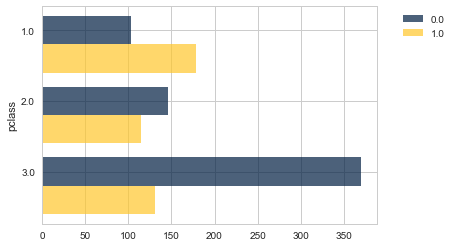

In [24]:
# Showing the counts

titanic_sub.pivot("survived", "pclass").barh("pclass")

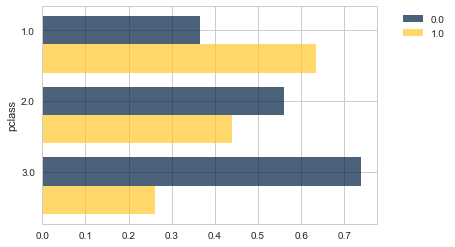

In [25]:
# Showing the conditional distributions

conditional_given_pclass.barh("pclass")

**Note:** If we want to detect associations, it is better to look at conditional distributions.